In [1]:
# To-do list:
# 1. Simulation 6000 ft of horizontal.
# 2. More dedicated QC plot
%cd ~/projects/mariner

[Errno 2] No such file or directory: '/rcp/rcp42/home/shenyaojin/projects/mariner'
/rcp/rcp42/home/shenyaojin/Documents/bakken_mariner/scripts/well_leakage_history_matching/old_from_haynesville


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
import os
os.listdir()

['101r_range_idx_revised.ipynb', '101_prototype.ipynb']

In [4]:
# Load necessary data: gauge and geometry
from fiberis.simulator.core import pds
from fiberis.analyzer.Data1D import Data1D_Gauge
from fiberis.analyzer.Geometry3D import DataG3D_md

In [5]:
# Define the datapath
gauge_data = "data/new/s_well/gauge_data"
from glob import glob
gauge_files = glob(gauge_data + "/*.npz")

In [6]:
# Gauge md
gauge_md_data = "data/new/s_well/geometry/gauge_md_swell.npz"
# Frac Hit md
frac_hit_md = glob("data/new/s_well/geometry/frac_hit/*.npz")
# sort the file
frac_hit_md = sorted(frac_hit_md)
frac_hit_md

[]

In [7]:
# Load and extract the data
gauge_md_dataframe = DataG3D_md.G3DMeasuredDepth()
gauge_md_dataframe.load_npz(gauge_md_data)
gauge_md = gauge_md_dataframe.data
# Load the gauge data
gauge_data_all = []
from tqdm import tqdm
start_time = datetime.datetime(2020, 4, 1)
end_time = datetime.datetime(2021, 1, 1)
for file in tqdm(gauge_files):
    gauge_data_dataframe = Data1D_Gauge.Data1DGauge()
    gauge_data_dataframe.load_npz(file)
    # Crop the data
    gauge_data_dataframe.crop(start_time, end_time)
    gauge_data_all.append(gauge_data_dataframe)

FileNotFoundError: [Errno 2] No such file or directory: 'data/new/s_well/geometry/gauge_md_swell.npz'

In [33]:
# Do the simulation
simulator = pds.PDS1D_MultiSource()

In [34]:
from fiberis.analyzer.Data2D import Data2D_XT_DSS
DASdata = Data2D_XT_DSS.DSS2D()
DASdata.load_npz("data/new/s_well/DASdata/LFDASdata_stg1_interval_swell.npz")

In [35]:
# Set up the grid. 6000 ft with Neumann BC; finer grid at frac hit location
mesh = np.linspace(DASdata.daxis[-1] -4700, DASdata.daxis[-1], 4700)
# Combine the frac hit location
frac_hit = []
for file in tqdm(frac_hit_md):
    frac_hit_dataframe = DataG3D_md.G3DMeasuredDepth()
    frac_hit_dataframe.load_npz(file)
    frac_hit.append(frac_hit_dataframe.data)

100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1885.97it/s]


In [36]:
# Convert frac hit to 1D array
frac_hit_sep = frac_hit.copy()
frac_hit = np.concatenate(frac_hit)

In [37]:
mesh = np.linspace(DASdata.daxis[-1] -6000, DASdata.daxis[-1], 6000)
# refine the mesh
from fiberis.utils import mesh_utils

for frac_hit_iter in frac_hit:
    mesh = mesh_utils.refine_mesh(mesh, [frac_hit_iter - 1, frac_hit_iter + 1], 10)

In [38]:
nx = len(mesh)

In [39]:
simulator.set_mesh(mesh)
simulator.set_bcs('Neumann', 'Neumann')
simulator.set_t0(0)
simulator.set_initial(np.ones_like(mesh) * gauge_data_all[5].data[0]) # Gauge 6 and gauge 7; stage 7 and 8

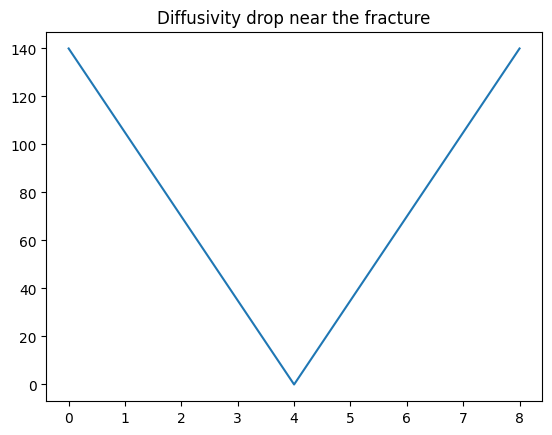

In [40]:
# Set up the diffusivity array
ratio = 0.000001
drop_array = np.linspace(1, ratio, 5)
drop_array_rev = drop_array[::-1][1:]
drop_array = np.concatenate([drop_array, drop_array_rev])
plt.figure()
plt.plot(drop_array * 140)
plt.title("Diffusivity drop near the fracture")
plt.show()

In [41]:
# Apply the diffusivity drop at frac hit
diffusivity_array = np.ones_like(mesh) * 140
for frac_hit_iter in frac_hit:
    idx, _ = mesh_utils.locate(mesh, frac_hit_iter)
    diffusivity_array[idx - 4: idx + 5] = drop_array * 140

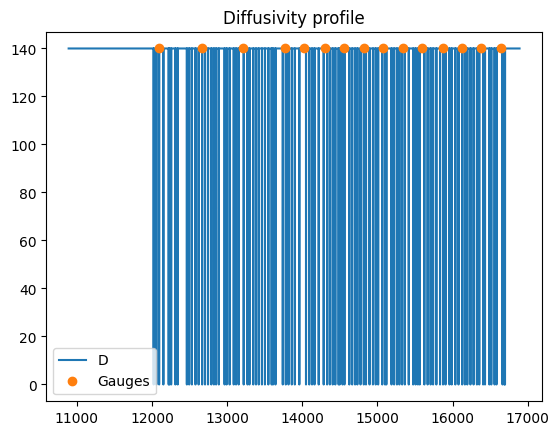

In [42]:
plt.figure()
plt.plot(mesh, diffusivity_array, label='D')
plt.plot(gauge_md, np.ones_like(gauge_md) * 140, 'o', label='Gauges')
plt.title("Diffusivity profile")
plt.legend()
plt.show()

In [147]:
simulator.set_diffusivity(diffusivity_array)

In [148]:
# Set up the source
gauge_dataframe_source = gauge_data_all[5] # Gauge 6; stage 7
# gauge_dataframe_source = np.repeat(gauge_dataframe_source, len(frac_hit_sep[-3]))
source_idx = []
source = []
for idx in range(len(frac_hit_sep[-3])):
    source_idx.append(mesh_utils.locate(mesh, frac_hit_sep[-3][idx])[0])
    source.append(gauge_dataframe_source)

simulator.set_source(source)
simulator.set_sourceidx(source_idx)

In [149]:
simulator.self_check()

True

In [150]:
simulator.solve(optimizer=False, t_total=gauge_dataframe_source.taxis[-1], dt=gauge_dataframe_source.taxis[-1]/40, print_progress=True)

Time array generated using t_total.


/home/shenyaojin/projects/mariner/fibeRIS/src/fiberis/simulator/solver/PDESolver_IMP.py:28: LinAlgWarning: Ill-conditioned matrix (rcond=1.82412e-21): result may not be accurate.
  x = la.solve(A, b)


Time: 593460.0 Source term: [8013.68, 8013.68, 8013.68, 8013.68, 8013.68, 8013.68]
Time: 1186920.0 Source term: [7365.4574, 7365.4574, 7365.4574, 7365.4574, 7365.4574, 7365.4574]
Time: 1780380.0 Source term: [5104.438999999999, 5104.438999999999, 5104.438999999999, 5104.438999999999, 5104.438999999999, 5104.438999999999]
Time: 2373840.0 Source term: [4543.3195000000005, 4543.3195000000005, 4543.3195000000005, 4543.3195000000005, 4543.3195000000005, 4543.3195000000005]
Time: 2967300.0 Source term: [5721.6179999999995, 5721.6179999999995, 5721.6179999999995, 5721.6179999999995, 5721.6179999999995, 5721.6179999999995]
Time: 3560760.0 Source term: [4617.4182, 4617.4182, 4617.4182, 4617.4182, 4617.4182, 4617.4182]
Time: 4154220.0 Source term: [4266.091, 4266.091, 4266.091, 4266.091, 4266.091, 4266.091]
Time: 4747680.0 Source term: [4045.899, 4045.899, 4045.899, 4045.899, 4045.899, 4045.899]
Time: 5341140.0 Source term: [3858.274, 3858.274, 3858.274, 3858.274, 3858.274, 3858.274]
Time: 59346

In [151]:
print(np.shape(simulator.snapshot))
print(len(mesh))

(41, 8318)
8318


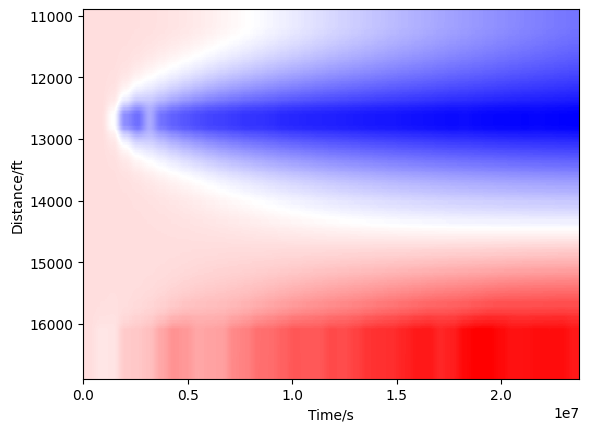

In [152]:
simulator.plot_solution()

In [153]:
# Calculate pressure drop
pressure_drop = simulator.snapshot[1, :] - simulator.snapshot[-1, :]

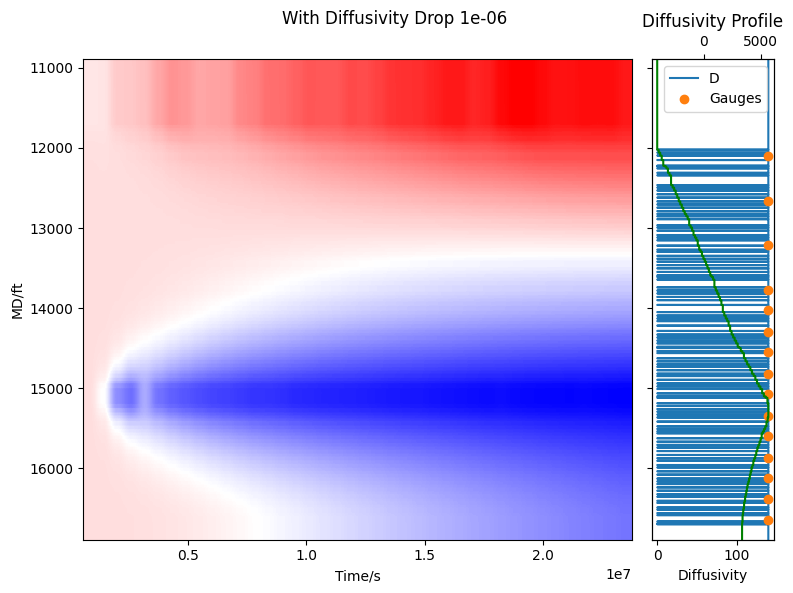

In [154]:
# Visualize the result
# Create figure
fig = plt.figure(figsize=(8, 6))
extent = [simulator.taxis[1], simulator.taxis[-1], mesh[-1], mesh[0]]
# Create main 4x4 subplot
ax1 = plt.subplot2grid((4, 5), (0, 0), rowspan=4, colspan=4)
img1 = ax1.imshow(simulator.snapshot[1:, :].T, aspect='auto', cmap='bwr', extent=extent)
ax1.set_xlabel("Time/s")
ax1.set_ylabel("MD/ft")
# Create the right-side 4x1 subplot
ax2 = plt.subplot2grid((4, 5), (0, 4), rowspan=4, colspan=1, sharey=ax1)
# Plot diffusivity vs. depth (transposed axes: x=diffusivity, y=mesh)
ax2.plot(diffusivity_array, mesh, label='D')
ax2.set_xlabel("Diffusivity")
# Plot gauge markers (constant x = 140, y = gauge_md)
img2 = ax2.plot(np.ones_like(gauge_md)*140, gauge_md, 'o', label='Gauges')
ax2.set_title("Diffusivity Profile")
ax2.set_ylim(mesh[-1], mesh[0])  # Match/improve orientation with main plot
ax2.legend()
# remove y tick in ax2, img2
plt.setp(ax2.get_yticklabels(), visible=False)
ax21 = ax2.twiny()
ax21.plot(pressure_drop, mesh, 'g', label='Pressure Drop')
# Display the blank grid
plt.tight_layout()
plt.suptitle(f"With Diffusivity Drop {ratio}")
plt.show()

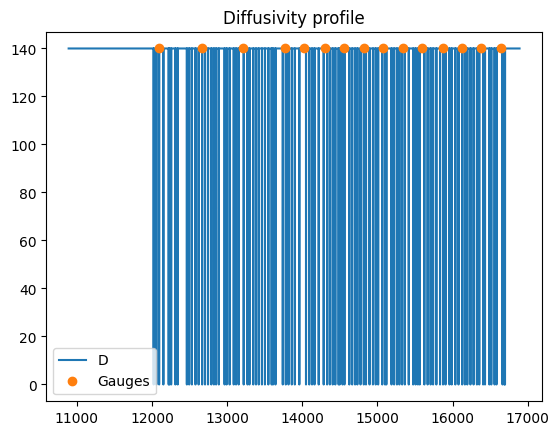

In [155]:
plt.figure()
plt.plot(mesh, diffusivity_array, label='D')
plt.plot(gauge_md, np.ones_like(gauge_md) * 140, 'o', label='Gauges')
plt.title("Diffusivity profile")
plt.legend()
plt.show()